In [99]:
from matplotlib import pyplot as plt

def display_image(img):
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


C:\workspace\evml\EVD3\workspace\data\mondriaan1 (1).JPG


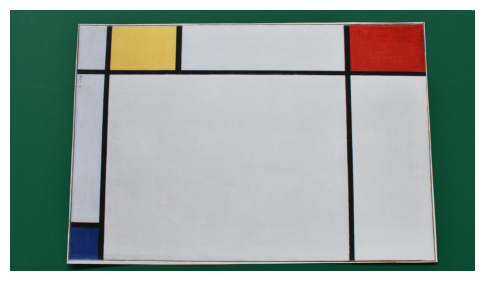

C:\workspace\evml\EVD3\workspace\data\mondriaan2 (1).JPG


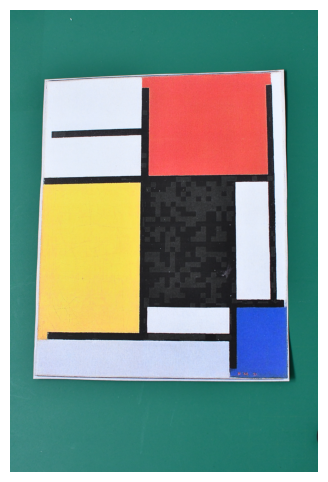

C:\workspace\evml\EVD3\workspace\data\mondriaan3 (1).JPG


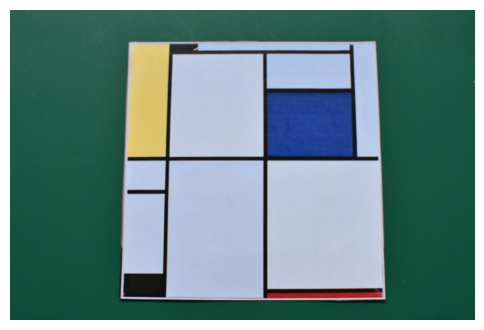

C:\workspace\evml\EVD3\workspace\data\mondriaan4 (1).JPG


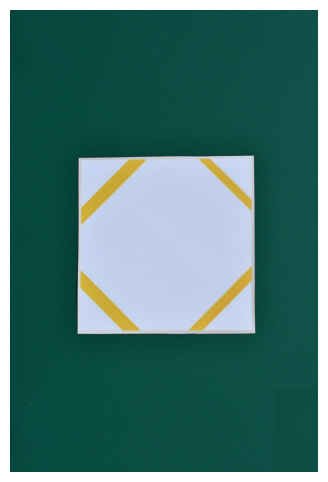

In [161]:
from pathlib import Path
import cv2 as cv
import os

folder = Path(r'C:\workspace\evml\EVD3\workspace\data')
folder_path = r'C:\workspace\evml\EVD3\workspace\data'
folder_path_1 = Path(r'C:\workspace\evml\EVD3\workspace\data\mondriaan1')

files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

img = cv.imread(os.path.join(folder_path, files[0]))
img2 = cv.imread(os.path.join(folder_path, files[1]))
img3 = cv.imread(os.path.join(folder_path, files[2]))
img4 = cv.imread(os.path.join(folder_path, files[3]))

img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_rgb1 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img_rgb2 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
img_rgb3 = cv.cvtColor(img4, cv.COLOR_BGR2RGB)

print(os.path.join(folder_path, files[0]))
display_image(img_rgb)

print(os.path.join(folder_path, files[1]))
display_image(img_rgb1)

print(os.path.join(folder_path, files[2]))
display_image(img_rgb2)

print(os.path.join(folder_path, files[3]))
display_image(img_rgb3)


In [101]:
def maskColor(img, min_hue, max_hue, invert=False):
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    light = (min_hue,50,50)
    dark  = (max_hue,255,255)

    mask = cv.inRange(img_hsv, light, dark)
    
    if invert:
        mask = cv.bitwise_not(mask)

    return mask

In [102]:
import numpy as np

def create_hue_histogram(img: np.ndarray, s_threshold: int = 30, v_threshold: int = 30, center_hue: int = -1) -> np.ndarray:
    """
    Create a meaningful hue histogram from an OpenCV image, excluding pixels with low saturation or value,
    with an option to center a specific hue.

    This function converts the input image to HSV color space, applies thresholds to exclude pixels
    with low saturation or value (which have meaningless hue), and then creates a histogram of the
    hue values for the remaining pixels.

    Args:
        img (np.ndarray): Input image in BGR format (OpenCV default).
        s_threshold (int, optional): Minimum saturation for a pixel to be included. Defaults to 30.
        v_threshold (int, optional): Minimum value for a pixel to be included. Defaults to 30.
        center_hue (int, optional): Hue value to center the histogram on. Range 0-179. 
                                    Default is -1 (no centering).        

    Returns:
        np.ndarray: The normalized hue histogram.    

    Note:
        - The function assumes the input image is in BGR format (OpenCV default).
        - The histogram is normalized to the range [0, 1].
        - Hue values in OpenCV range from 0 to 179 (for 8-bit images).
    """
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv)

    # Shift hue if center_hue is specified
    if 0 <= center_hue <= 179:
        h = (h - center_hue + 90) % 180    

    # Create a mask for meaningful colors
    mask = cv.bitwise_and(cv.inRange(s, s_threshold, 255), cv.inRange(v, v_threshold, 255))
    
    # Calculate histogram for masked hue values
    hist = cv.calcHist([h], [0], mask, [180], [0, 180])

    # Normalize the histogram
    cv.normalize(hist, hist, 0, 1, cv.NORM_MINMAX)    
    
    return hist

In [103]:
from matplotlib.colors import hsv_to_rgb

def plot_hue_histogram(hist: np.ndarray, center_hue: int = -1):
    """
    Plot a hue histogram with a color chart along the x-axis.

    Args:
        hist (np.ndarray): The hue histogram to plot.
        center_hue (int, optional): The hue value the histogram is centered on. 
                                    Default is -1 (no centering).
    """
    fig, (ax_hist, ax_color) = plt.subplots(2, 1, figsize=(10, 6), 
                                            gridspec_kw={'height_ratios': [4, 1]}, 
                                            sharex=True)
    
    # Plot the histogram
    ax_hist.plot(hist.ravel())
    ax_hist.set_title('Hue Histogram')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_xlim([0, 180])
    
    # Create a color array for the colorbar
    hue_range = np.linspace(0, 1, 180)
    saturation = np.ones_like(hue_range)
    value = np.ones_like(hue_range)
    hsv_colors = np.stack((hue_range, saturation, value), axis=1)
    rgb_colors = hsv_to_rgb(hsv_colors)
    
    # Plot the color chart
    ax_color.imshow([rgb_colors], aspect='auto', extent=[0, 180, 0, 1])
    ax_color.set_yticks([])
    
    # Set x-axis label
    plt.xlabel('Hue Value' + (' (Shifted)' if 0 <= center_hue <= 179 else ''))
    
    plt.tight_layout()
    plt.show()

In [152]:
def getLargestContour(img_BW):
    """ Return largest contour in foreground as an nd.array """
    contours, hier = cv.findContours(img_BW.copy(), cv.RETR_EXTERNAL,
                                     cv.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv.contourArea)
    
    return np.squeeze(contour)

def getContourExtremes(contour):
    """ Return contour extremes as an tuple of 4 tuples """
    # determine the most extreme points along the contour
    left = contour[contour[:, 0].argmin()]
    right = contour[contour[:, 0].argmax()]
    top = contour[contour[:, 1].argmin()]
    bottom = contour[contour[:, 1].argmax()]

    return np.array((left, right, top, bottom))

In [155]:
def getContourFeatures(contour):
    """ Return some contour features
    """    
    # basic contour features
    area = cv.contourArea(contour)
    perimeter = cv.arcLength(contour, True)
    extremePoints = getContourExtremes(contour)
    return extremePoints

    # get contour convexity defect depths
    # see https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
    defects = getConvexityDefects(contour)

    defect_depths = defects[:,-1]/256.0 if defects is not None else np.zeros((6,1))

    # select only the 6 largest depths
    defect_depths = np.flip(np.sort(defect_depths))[0:6]

    # compile a feature vector
    features = np.append(defect_depths, (area,perimeter))

    return (features, defects)

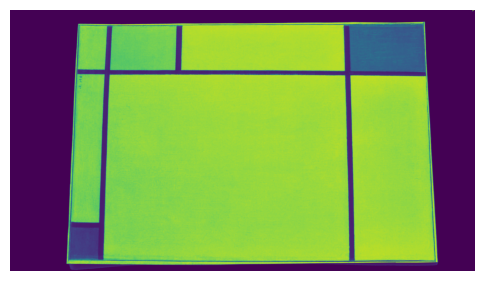

[[ 674 3023]
 [5127 3021]
 [4943  151]
 [ 764 3116]]


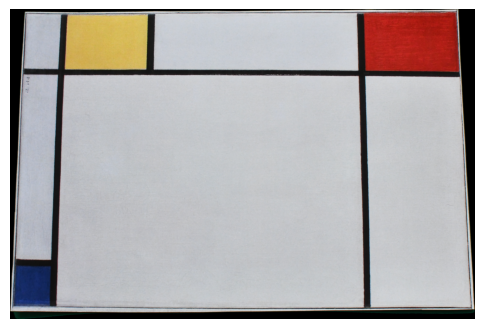

In [ ]:
mask = maskColor(img_rgb, 67, 85, True)
masked_img = cv.bitwise_and(img_rgb, img_rgb, mask=mask)

hist = create_hue_histogram(masked_img)
# display_image(masked_img)
# plot_hue_histogram(hist)

gray = cv.cvtColor(masked_img, cv.COLOR_RGB2GRAY)
contour = getLargestContour(gray)
features = getContourFeatures(contour)
left, right, top, bottom = features
x_min = left[0]
x_max = right[0]
y_min = top[1]
y_max = bottom[1]
cropped_img = masked_img[y_min:y_max, x_min:x_max]

print(features)
display_image(cropped_img)

# display_image(contour)

# mask2 = maskColor(img_rgb2, 67, 85, True)
# masked_img2 = cv.bitwise_and(img_rgb2, img_rgb2, mask=mask2)

# hist = create_hue_histogram(masked_img2)
# display_image(masked_img2)
# plot_hue_histogram(hist)

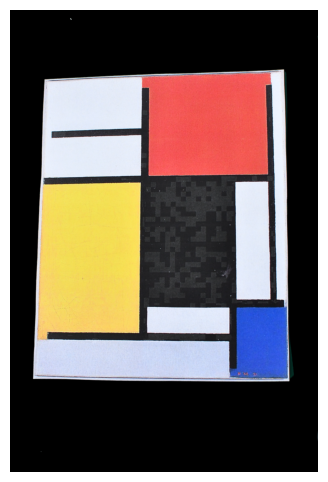

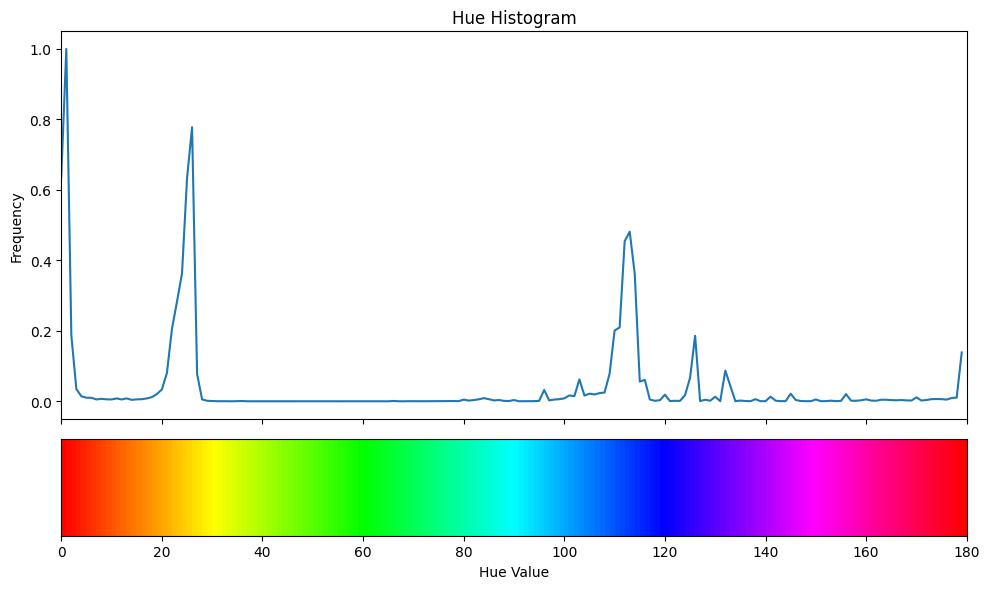

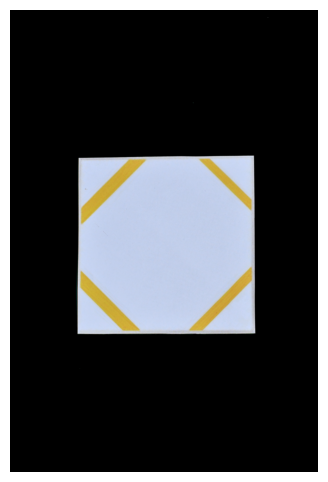

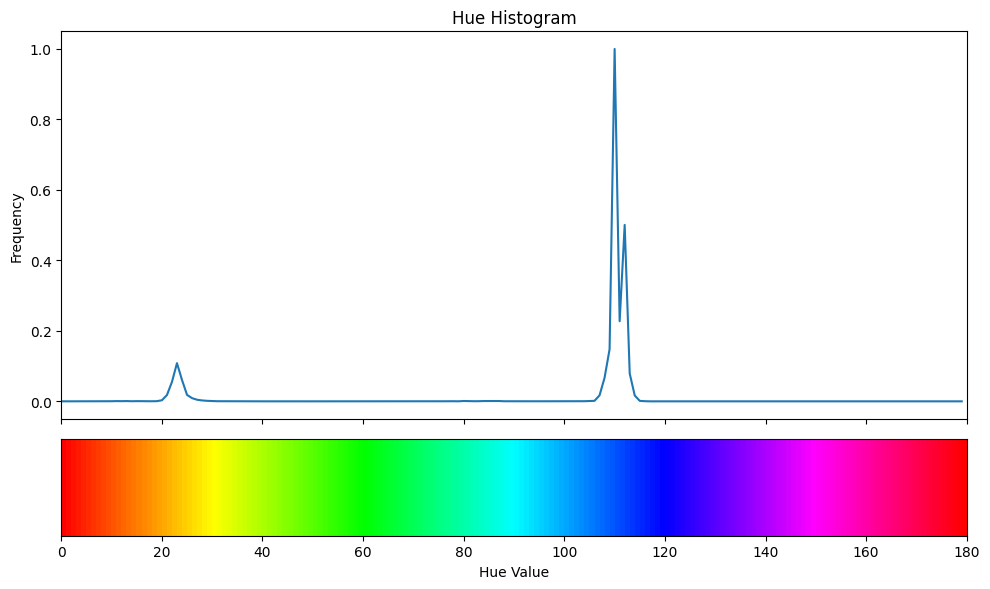

In [105]:
mask1 = maskColor(img_rgb1, 82, 95, True)
masked_img1 = cv.bitwise_and(img_rgb1, img_rgb1, mask=mask1)

hist = create_hue_histogram(masked_img1)
display_image(masked_img1)
plot_hue_histogram(hist)

mask3 = maskColor(img_rgb3, 82, 95, True)
masked_img3 = cv.bitwise_and(img_rgb3, img_rgb3, mask=mask3)

hist = create_hue_histogram(masked_img3)
display_image(masked_img3)
plot_hue_histogram(hist)

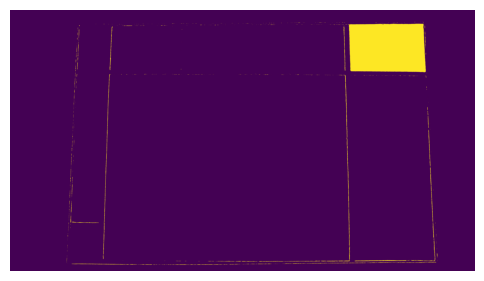

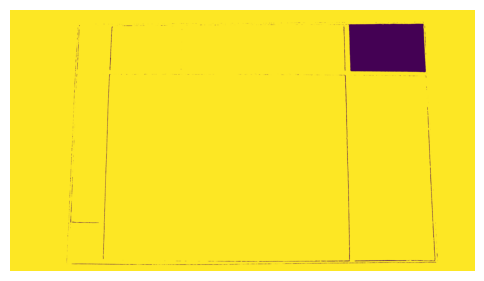

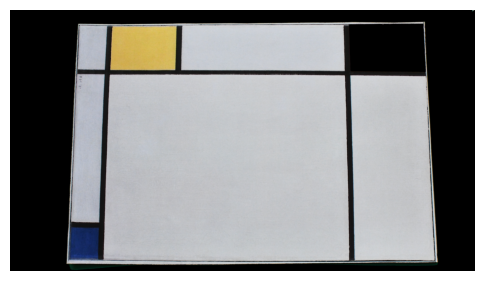

In [106]:
mask_upper = maskColor(img_rgb, 0, 11, False)
mask_lower = maskColor(img_rgb, 169, 180, False)
red_mask = cv.bitwise_or(mask_upper, mask_lower)

display_image(red_mask)

not_red_mask = cv.bitwise_not(red_mask)

display_image(not_red_mask)

img_no_red = cv.bitwise_and(masked_img, masked_img, mask=not_red_mask)

display_image(img_no_red)

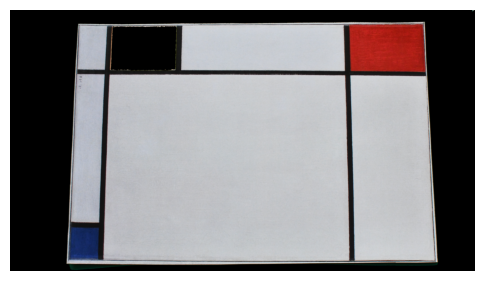

In [107]:
yellow_mask = maskColor(img_rgb, 20, 30, False)
not_yellow_mask = cv.bitwise_not(yellow_mask)
img_no_yellow = cv.bitwise_and(masked_img, masked_img, mask=not_yellow_mask)

display_image(img_no_yellow)

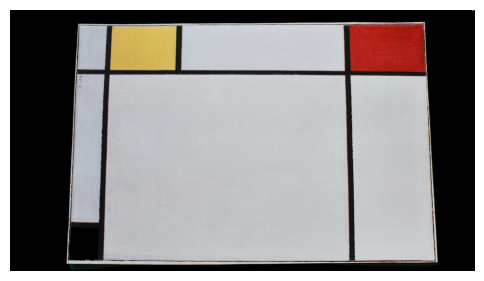

In [108]:
blue_mask = maskColor(img_rgb, 100, 130, False)
not_blue_mask = cv.bitwise_not(blue_mask)
img_no_blue = cv.bitwise_and(masked_img, masked_img, mask=not_blue_mask)

display_image(img_no_blue)

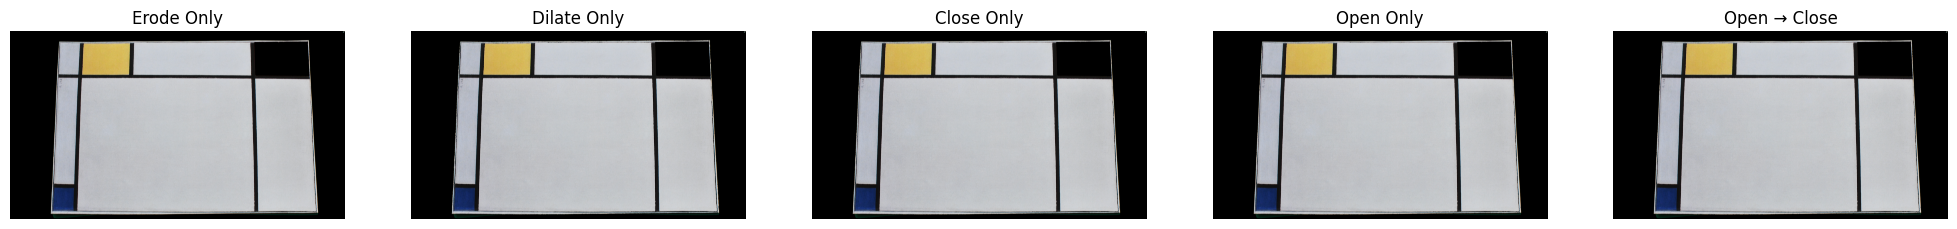

In [109]:
import cv2 as cv
from matplotlib import pyplot as plt

kernel = np.ones((3, 3), np.uint8)

# --- 1. Erode only ---
red_mask_erode = cv.erode(red_mask, kernel, iterations=1)
not_red_erode = cv.bitwise_not(red_mask_erode)
img_no_red_erode = cv.bitwise_and(masked_img, masked_img, mask=not_red_erode)

# --- 2. Dilate only ---
red_mask_dilate = cv.dilate(red_mask, kernel, iterations=1)
not_red_dilate = cv.bitwise_not(red_mask_dilate)
img_no_red_dilate = cv.bitwise_and(masked_img, masked_img, mask=not_red_dilate)

# --- 3. Close only ---
red_mask_close = cv.morphologyEx(red_mask, cv.MORPH_CLOSE, kernel)
not_red_close = cv.bitwise_not(red_mask_close)
img_no_red_close = cv.bitwise_and(masked_img, masked_img, mask=not_red_close)

# --- 4. Open only ---
red_mask_open = cv.morphologyEx(red_mask, cv.MORPH_OPEN, kernel)
not_red_open = cv.bitwise_not(red_mask_open)
img_no_red_open = cv.bitwise_and(masked_img, masked_img, mask=not_red_open)

# --- 5. Open → Close ---
red_mask_open_close = cv.morphologyEx(red_mask, cv.MORPH_OPEN, kernel)
red_mask_open_close = cv.morphologyEx(red_mask_open_close, cv.MORPH_CLOSE, kernel)
not_red_open_close = cv.bitwise_not(red_mask_open_close)
img_no_red_open_close = cv.bitwise_and(masked_img, masked_img, mask=not_red_open_close)

# --- Display all variants ---
fig, axes = plt.subplots(1, 5, figsize=(25, 6))

axes[0].imshow(img_no_red_erode)
axes[0].set_title("Erode Only")
axes[0].axis('off')

axes[1].imshow(img_no_red_dilate)
axes[1].set_title("Dilate Only")
axes[1].axis('off')

axes[2].imshow(img_no_red_close)
axes[2].set_title("Close Only")
axes[2].axis('off')

axes[3].imshow(img_no_red_open)
axes[3].set_title("Open Only")
axes[3].axis('off')

axes[4].imshow(img_no_red_open_close)
axes[4].set_title("Open → Close")
axes[4].axis('off')

plt.show()


In [110]:
def color_percentage(mask):
    """Calculate % of pixels in mask"""
    total_pixels = mask.size
    color_pixels = cv.countNonZero(mask)
    return (color_pixels / total_pixels) * 100

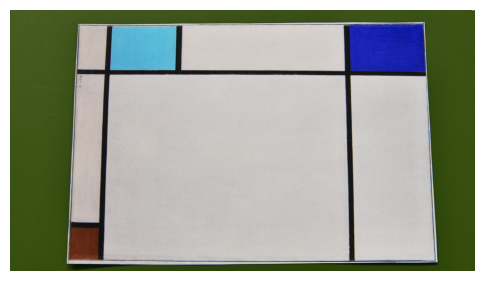

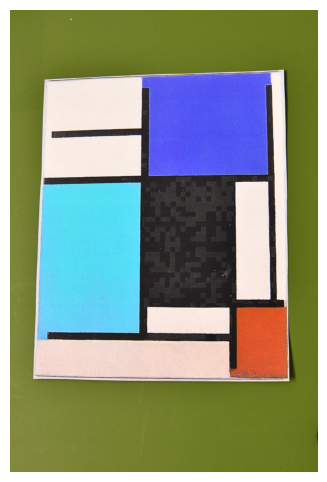

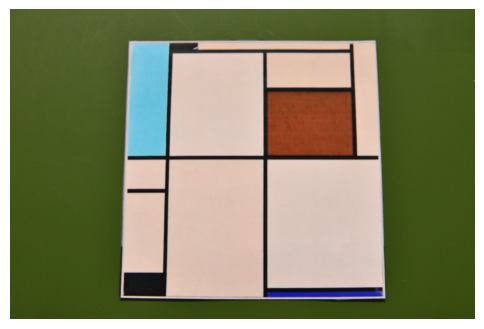

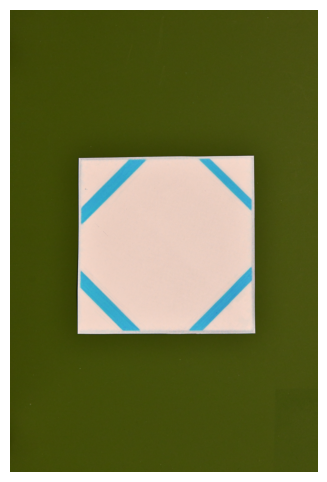

Yellow color percentages in mondriaan1 images: [0.2370058517318092, 0.0775008171928963, 0.019027900342594176, 0.02522854657481578]
Blue color percentages in mondriaan1 images: [3.6016410607324483, 9.133730997572648, 0.6152193094997144, 0.045892526875638606]
Red color percentages in mondriaan1 images: [0.7757578709891522, 2.914826500255069, 12.127800885390323, 0.1368256573350571]
red color percentages:
3.0669637607666753
3.714187253799571
3.261926022282976
3.3921573220742567
3.2705097359408533
yellow color percentages: 0.02522854657481578
blue color percentages: 0.045892526875638606


In [175]:

yellows = []
blues = []
reds = []


aspect_ratios = []

for file_path in folder.glob("*.JPG"):
    img = cv.imread(str(file_path))
    mask = maskColor(img, 67, 85, True)
    masked_img = cv.bitwise_and(img, img, mask=mask)

    gray = cv.cvtColor(masked_img, cv.COLOR_RGB2GRAY)
    contour = getLargestContour(gray)
    left, right, top, bottom = getContourExtremes(contour)
    x_min, x_max = left[0], right[0]
    y_min, y_max = top[1], bottom[1]

    # Cropped image
    cropped_img = masked_img[y_min:y_max, x_min:x_max]
    display_image(cropped_img)

    # Color percentages
    yellow_mask = maskColor(cropped_img, 20, 30, False)
    yellows.append(color_percentage(yellow_mask))

    blue_mask = maskColor(cropped_img, 100, 130, False)
    blues.append(color_percentage(blue_mask))

    mask_upper = maskColor(cropped_img, 0, 11, False)
    mask_lower = maskColor(cropped_img, 169, 180, False)
    red_mask = cv.bitwise_or(mask_upper, mask_lower)
    reds.append(color_percentage(red_mask))

    # Aspect ratio
    width = x_max - x_min
    height = y_max - y_min
    aspect_ratios.append(width / height if height > 0 else np.nan)



print(f"Yellow color percentages in mondriaan1 images: {yellows}")
print(f"Blue color percentages in mondriaan1 images: {blues}")
print(f"Red color percentages in mondriaan1 images: {reds}")

print("red color percentages:")
print(color_percentage(red_mask_erode))
print(color_percentage(red_mask_dilate))
print(color_percentage(red_mask_open))
print(color_percentage(red_mask_close))
print(color_percentage(red_mask_open_close))

print(f"yellow color percentages: {color_percentage(yellow_mask)}")

print(f"blue color percentages: {color_percentage(blue_mask)}")


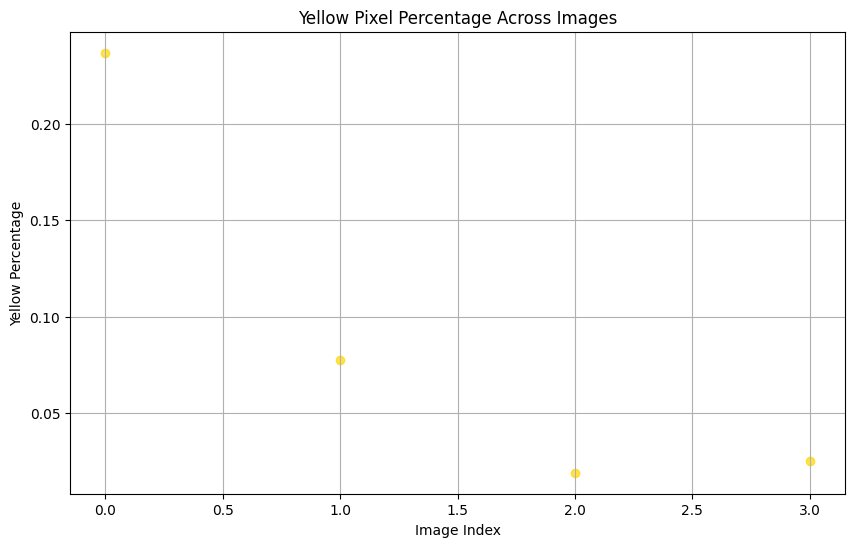

In [150]:
import matplotlib.pyplot as plt

# Scatterplot: image index vs yellow percentage
plt.figure(figsize=(10, 6))
plt.scatter(range(len(yellows)), yellows, color='gold', alpha=0.7)
plt.xlabel("Image Index")
plt.ylabel("Yellow Percentage")
plt.title("Yellow Pixel Percentage Across Images")
plt.grid(True)
plt.show()


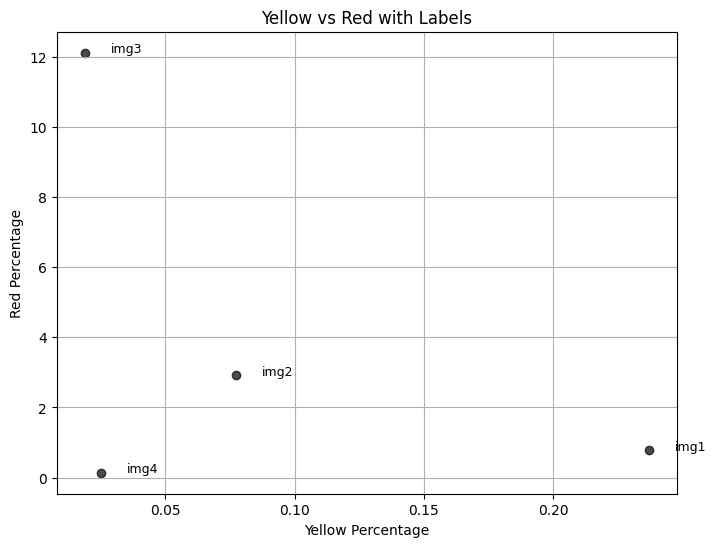

In [151]:
import matplotlib.pyplot as plt

image_names = ["img1", "img2", "img3", "img4"]  # or file_path.stem for real filenames

plt.figure(figsize=(8,6))
plt.scatter(yellows, reds, color='black', alpha=0.7)

for i, name in enumerate(image_names):
    plt.text(yellows[i]+0.01, reds[i]+0.01, name, fontsize=9)  # offset slightly

plt.xlabel("Yellow Percentage")
plt.ylabel("Red Percentage")
plt.title("Yellow vs Red with Labels")
plt.grid(True)
plt.show()

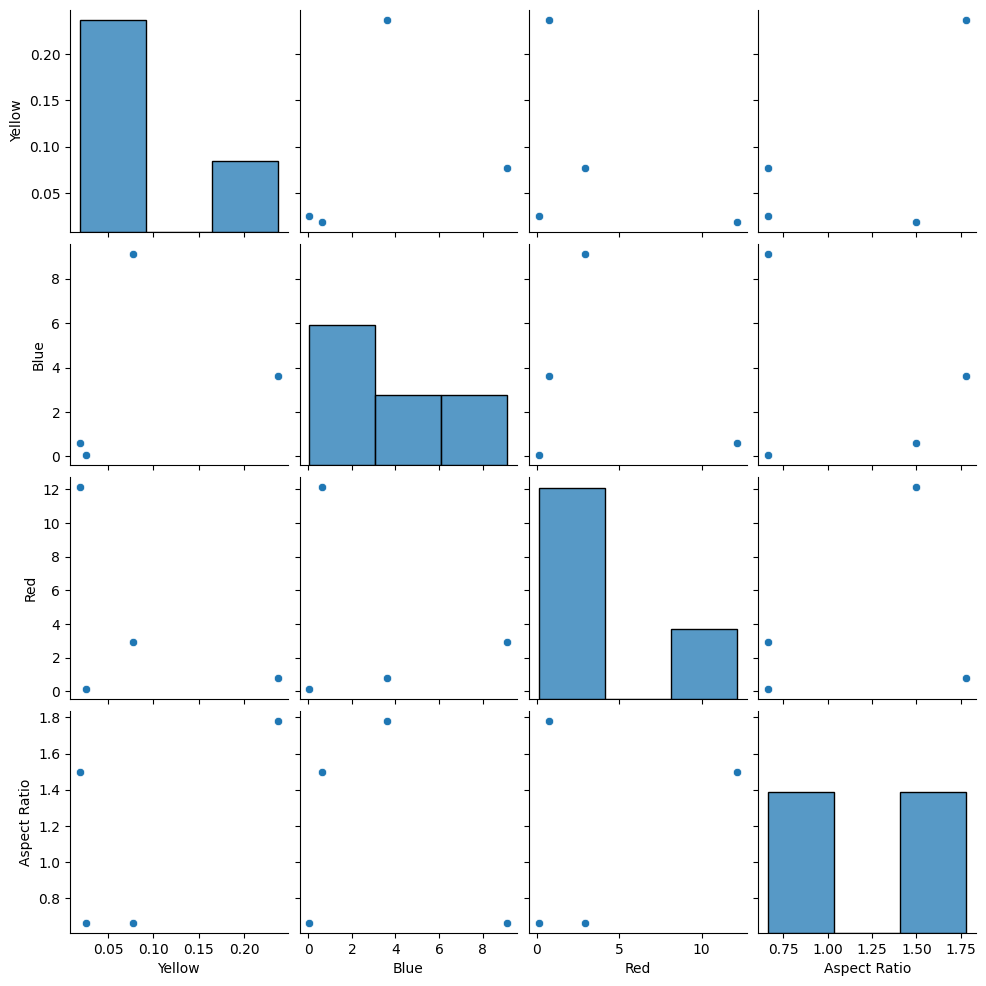

In [174]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({
    "Yellow": yellows,
    "Blue": blues,
    "Red": reds,
    "Aspect Ratio": aspect_ratios
})


sns.pairplot(df)
plt.show()


In [112]:
import numpy as np
import cv2 as cv

# Convert to float to avoid integer division
img_float = masked_img.astype(np.float32)

# Sum of all channels per pixel
sum_channels = img_float.sum(axis=2, keepdims=True)  # shape (H, W, 1)
# Avoid division by zero
sum_channels[sum_channels == 0] = 1

# Calculate ratios for each channel
ratios = img_float / sum_channels  # shape (H, W, 3), values in [0,1]

# Now calculate variance for each color ratio across all pixels
variance_per_channel = np.var(ratios.reshape(-1, 3), axis=0)  # [var_R, var_G, var_B]

print("Variance for Red ratio:", variance_per_channel[0])
print("Variance for Green ratio:", variance_per_channel[1])
print("Variance for Blue ratio:", variance_per_channel[2])


Variance for Red ratio: 0.027730769
Variance for Green ratio: 0.019125516
Variance for Blue ratio: 0.026832592


In [113]:
def center_of_mass(mask):
    """Compute the center of mass of a binary mask."""
    moments = cv.moments(mask)
    if moments["m00"] == 0:
        return None  # no pixels in mask
    cx = moments["m10"] / moments["m00"]
    cy = moments["m01"] / moments["m00"]
    return (int(cx), int(cy))

In [114]:
def calc_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

In [115]:
height, width = img_rgb.shape[:2]
image_center = (width//2, height//2)
image_diag = np.sqrt(width**2 + height**2)
print(height, width, image_center, image_diag)

3128 5568 (2784, 1564) 6386.470699846669


In [116]:

dist = []
norm = []

for file_path in folder.rglob("*.JPG"):
    print(file_path)
    img = cv.imread(str(file_path))
    mask = maskColor(img, 67, 85, True)
    masked_img = cv.bitwise_and(img, img, mask=mask)
    mask_upper = maskColor(masked_img, 0, 11, False)
    mask_lower = maskColor(masked_img, 169, 180, False)
    red_mask = cv.bitwise_or(mask_upper, mask_lower)
    com_red = center_of_mass(red_mask)
    dista = calc_distance(com_red, image_center)
    normalized_distance = dista / image_diag
    dist.append(dista)
    norm.append(normalized_distance)
    print(dista, normalized_distance)
    print(com_red)



C:\workspace\evml\EVD3\workspace\data\mondriaan1 (1).JPG
2214.170950943039 0.3466971125376334
(931, 2776)
C:\workspace\evml\EVD3\workspace\data\mondriaan2 (1).JPG
2424.089519799135 0.3795663729980526
(2941, 3983)
C:\workspace\evml\EVD3\workspace\data\mondriaan3 (1).JPG
369.655244788979 0.05788098969871638
(3066, 1803)
C:\workspace\evml\EVD3\workspace\data\mondriaan4 (1).JPG
1596.8625488751372 0.250038342603447
(1605, 2641)


In [117]:
distance = calc_distance(com_red, np.array(image_center))

normalized_distance = distance / image_diag

print(distance, normalized_distance)

1596.8625488751372 0.250038342603447


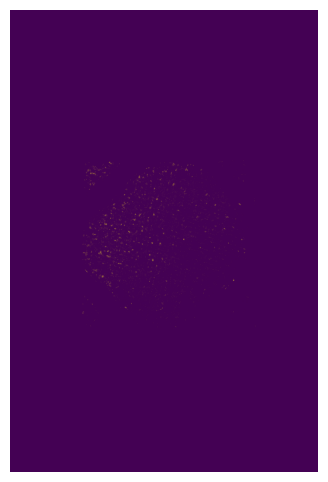

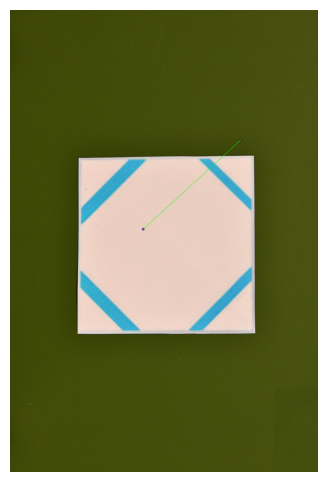

In [118]:
img_with_com = masked_img.copy()
cv.circle(img_with_com, com_red, radius=10, color=(0,0,255), thickness=-1)  # BGR
cv.circle(img_with_com, com_red, radius=15, color=(0,0,0), thickness=2)    # black border
cv.circle(img_with_com, image_center, radius=5, color=(255,0,0), thickness=-1)  # blue dot
cv.circle(img_with_com, image_center, radius=15, color=(0,0,0), thickness=2)
cv.line(img_with_com, image_center, com_red, color=(0,255,0), thickness=3)
display_image(red_mask)
display_image(img_with_com)

In [119]:
import cv2 as cv
import numpy as np
from pathlib import Path
from scipy.stats import entropy

def color_diversity(img: np.ndarray, s_threshold: int = 30, v_threshold: int = 30) -> float:
    """
    Compute color diversity as the entropy of the hue histogram.
    """
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)

    # Mask to ignore gray/black/white pixels
    mask = cv.bitwise_and(cv.inRange(s, s_threshold, 255),
                          cv.inRange(v, v_threshold, 255))

    # Hue histogram (normalized)
    hist = cv.calcHist([h], [0], mask, [180], [0, 180]).flatten()
    hist = hist / hist.sum() if hist.sum() > 0 else hist

    # Entropy = diversity score
    return float(entropy(hist + 1e-6))


In [120]:
from scipy.signal import find_peaks

def color_peaks(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    mask = cv.bitwise_and(cv.inRange(s, 30, 255), cv.inRange(v, 30, 255))
    hist = cv.calcHist([h], [0], mask, [180], [0, 180]).flatten()
    hist = hist / hist.sum() if hist.sum() > 0 else hist
    peaks, _ = find_peaks(hist, height=0.01)  # adjust height
    return len(peaks)

In [121]:
def unique_hues(img, threshold=0.01):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    mask = cv.bitwise_and(cv.inRange(s, 30, 255), cv.inRange(v, 30, 255))
    hist = cv.calcHist([h], [0], mask, [180], [0, 180]).flatten()
    hist = hist / hist.sum() if hist.sum() > 0 else hist
    return int(np.sum(hist > threshold))


In [122]:
def hue_variance(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    mask = (s > 30) & (v > 30)
    return float(np.var(h[mask]))

In [123]:
import cv2 as cv

vars = []
unis = []
peas = []
divs = []

for file_path in folder.rglob("*.JPG"):
    print(file_path)
    img = cv.imread(str(file_path))
    mask = maskColor(img, 67, 85, True)
    masked_img = cv.bitwise_and(img, img, mask=mask)
    var = hue_variance(img)
    vars.append(var)
    uni = unique_hues(img)
    unis.append(uni)
    pea = color_peaks(img)
    peas.append(pea)
    div = color_diversity(img)
    divs.append(div)
    print(var)
    print(uni)
    print(pea)
    print(div)

C:\workspace\evml\EVD3\workspace\data\mondriaan1 (1).JPG
840.417108566194
10
4
2.4235129356384277
C:\workspace\evml\EVD3\workspace\data\mondriaan2 (1).JPG
1363.879918661742
19
5
2.8114919662475586
C:\workspace\evml\EVD3\workspace\data\mondriaan3 (1).JPG
413.7536610384526
12
4
2.4806013107299805
C:\workspace\evml\EVD3\workspace\data\mondriaan4 (1).JPG
201.76030210545318
9
3
1.951134443283081


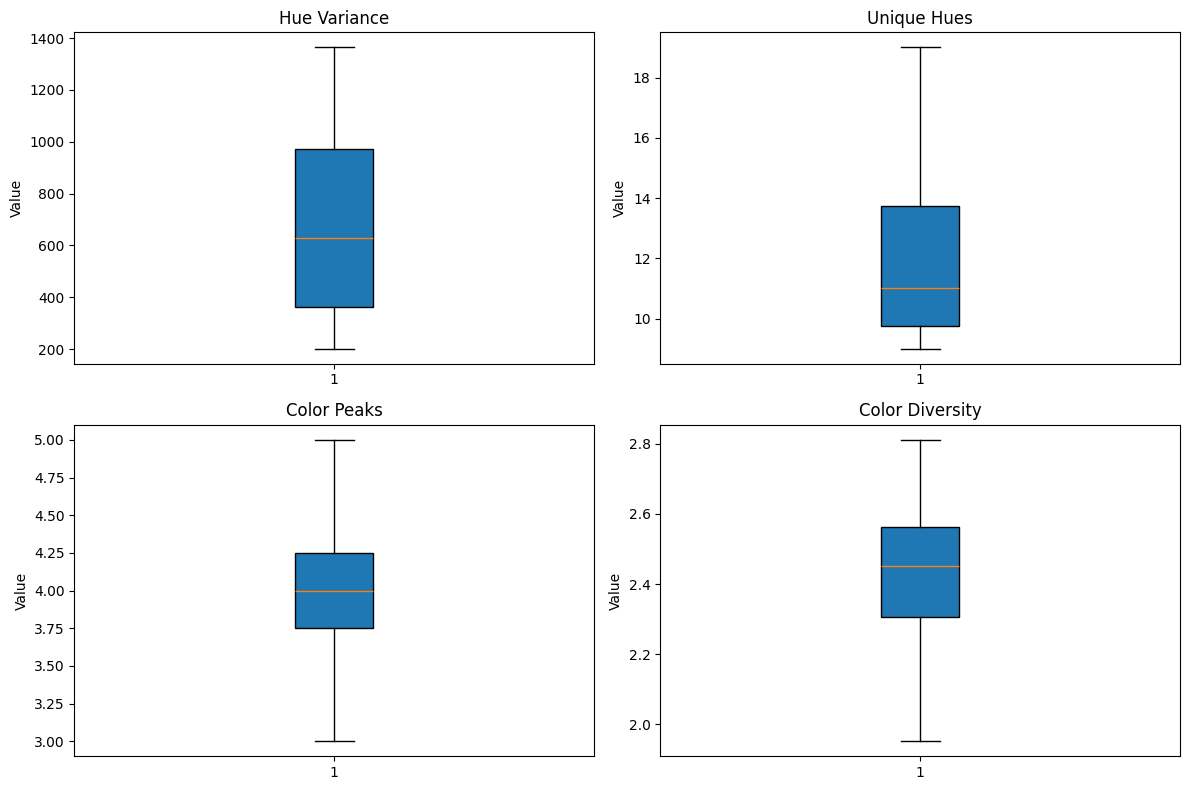

In [124]:
import matplotlib.pyplot as plt

features = {
    "Hue Variance": vars,
    "Unique Hues": unis,
    "Color Peaks": peas,
    "Color Diversity": divs
}

plt.figure(figsize=(12, 8))

for i, (name, values) in enumerate(features.items(), 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 cols
    plt.boxplot(values, patch_artist=True)
    plt.title(name)
    plt.ylabel("Value")

plt.tight_layout()
plt.show()


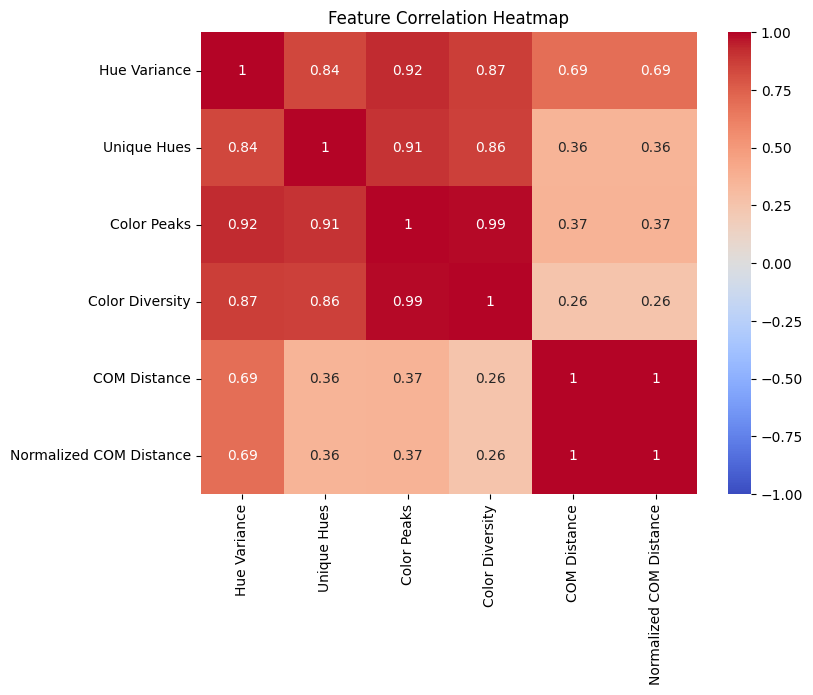

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Put all features into a DataFrame
df = pd.DataFrame({
    "Hue Variance": vars,
    "Unique Hues": unis,
    "Color Peaks": peas,
    "Color Diversity": divs,
    "COM Distance": dist,
    "Normalized COM Distance": norm
})

# Compute correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()
